# Annotating barrier condition in MetaChat

## Brief introduction

In MetaChat, barrier conditions define anatomical or structural boundaries that restrict metabolite diffusion and cell–cell communication. Annotating these barriers is an essential step to ensure that inferred communication flows respect realistic tissue morphology. This tutorial introduces how to annotate barrier regions in a spatial dataset.

We use the Visium HD dataset of  [mouse small intestine](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine). In this dataset, the tissue is spirally rolled to fit within the capture area for imaging and sequencing. As a result, regions that are spatially distant in the real anatomy may appear adjacent in the image plane, causing the Euclidean distance in the section to deviate from the true anatomical distance. This makes barrier annotation and distance correction essential for realistic modeling of metabolite transport and communication.

<img src="../../_static/image/identify_barrier/identify_barrier1.jpg" alt="identify_barrier1" width="400"/>

## Installation

First, we need to install the squidpy package with Napari by using `pip install 'squidpy[interactive]'` in your environment.

:::{seealso}
For basic usage of Napari, please see [Squidpy document](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_napari.html#annotate-tissue-regions-with-the-shape-layer) 
:::

## Usage

In [15]:
# Importing packages
import os
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import metachat as mc

In [2]:
# Setting your work directory
os.chdir("/Users/songhao/Library/CloudStorage/OneDrive-UCIrvine/2_Unpublished_work/1_Metabolite_Chat/4_Codes/tutorials/")

In [3]:
import sys
sys.path.append("/Users/songhao/Library/CloudStorage/OneDrive-UCIrvine/2_Unpublished_work/1_Metabolite_Chat/4_Codes/tutorials/MetaChat-main/")
import metachat_new as mc

For spatial transcriptome and spatial metabolome combined data by [tutorial](https://metachat.readthedocs.io/en/latest/tutorials/realistic_data/multi-omics_data.html), we can download processed data from [zenodo](https://zenodo.org/records/12629999). For the convenience of presentation, we performed our analysis on a subset of the data.

In [4]:
adata = sc.read('datasets/mouse_small_intestine/adata_combined_subset.h5ad')
image = adata.uns['spatial']['Visium_HD_Mouse_Small_Intestine_lowres_image']['images']['lowres']
img = sq.im.ImageContainer(image, 
                           library_id='Visium_HD_Mouse_Small_Intestine_lowres_image', 
                           scale=adata.uns['spatial']['Visium_HD_Mouse_Small_Intestine_lowres_image']['scalefactors']['tissue_lowres_scalef'])

:::{hint}
You can check the save information of your images in `adata.uns['spatial']`. The parameter `scale` in `sq.im.ImageContainer` is very important.
:::

Next, please activate interactive interface.

In [6]:
viewer = img.interactive(adata)

/Users/songhao/miniforge3/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactive/_utils.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("clusters")[[0, 1]].apply(lambda g: list(np.median(g.values, axis=0)))
Traceback (most recent call last):
  File "/Users/songhao/miniforge3/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactive/_widgets.py", line 41, in <lambda>
    self.itemDoubleClicked.connect(lambda item: self._onAction((item.text(),)))
  File "/Users/songhao/miniforge3/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactive/_widgets.py", line 146, in _onAction
    self._controller.add_points(vec, key=item, layer_name=name)
  File "/Users/songhao/miniforge3/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactiv

We can see a interface like this:

<img src="../../_static/image/identify_barrier/barrier_1.jpg" alt="barrier_1" width="1000"/>

Click `new shapes layer`, and click `Add path` to outline the boundary of the barrier. Then you choose that layer and click `File` and `Save selected layers` to the folder, you will get a csv file for line segments of barrier.

<img src="../../_static/image/identify_barrier/barrier_2.2.jpg" alt="barrier_2.2" width="1000"/>

<img src="../../_static/image/identify_barrier/barrier_3.jpg" alt="barrier_3" width="1000"/>

MetaChat provides a function `mc.pp.load_barrier_segments` to import this barrier information. The coordinate order in Napari may differ from that in Visium; you can define the order using `coord_cols`. The adata uses `tissue_hires_scalef` coordinates during import, while the images use `tissue_lowres_scalef`. Since we directly annotate barriers on the images, we should adjust the `scale` to align with the adata data.

In [12]:
dict_scale = adata.uns['spatial']['Visium_HD_Mouse_Small_Intestine_lowres_image']['scalefactors']
scale = dict_scale['tissue_hires_scalef']/dict_scale['tissue_lowres_scalef']
barrier_segs = mc.pp.load_barrier_segments("datasets/mouse_small_intestine/barrier.csv", coord_cols=("axis-2", "axis-1"), scale=scale)

We can use simple visualization to check whether the barrier coordinates are correct.

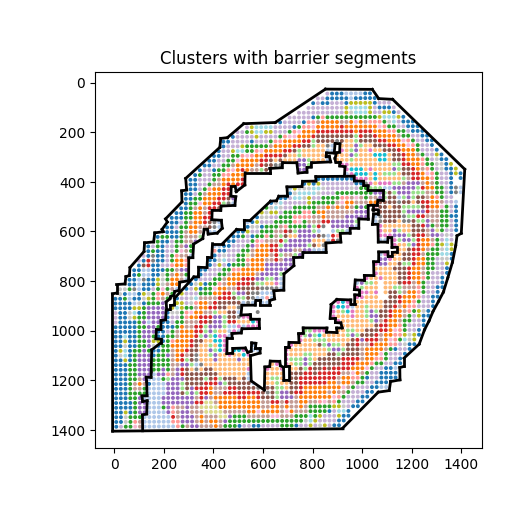

In [17]:
# Check barriers
clusters = adata.obs["Cluster"] if "Cluster" in adata.obs else None
XY = np.asarray(adata.obsm["spatial"], float)

fig, ax = plt.subplots(figsize=(5,5))
cats = pd.Categorical(clusters)
ax.scatter(XY[:,0], XY[:,1], s=8, c=cats.codes, cmap="tab20", edgecolor="none")

for (a, b) in barrier_segs:
    x = [a[0], b[0]]
    y = [a[1], b[1]]
    ax.plot(x, y, lw=2, c="black")

ax.set_aspect("equal", adjustable="box")
ax.invert_yaxis()
ax.set_title("Clusters with barrier segments")
plt.show()

Then, this `barrier_segs` can be used in the function `mc.pp.compute_costDistance` of computing cost distance  in optimal transport. Please see detailed application in the tutorial XXX.